In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# Make sure we don't get any GPU errors
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### Data downloading

In [4]:
zip_path = tf.keras.utils.get_file(
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        fname='mini_speech_commands.zip',
        extract=True,
        cache_dir='.', cache_subdir='data')
        
data_dir = os.path.join('.', 'data', 'mini_speech_commands')

In [7]:
def readFile(file):
  elems = []
  fp = open(file,'r')
  for f in fp:
    f_strip = f.strip().replace('/','\\')
    if f_strip != '':
      elems.append(f_strip)
    
  return elems

train_files= tf.random.shuffle(readFile('./splitFiles/kws_train_split.txt'))
val_files = tf.random.shuffle(readFile('./splitFiles/kws_val_split.txt'))
test_files =tf.random.shuffle(readFile('./splitFiles/kws_test_split.txt'))

In [8]:
train_files[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\mini_speech_commands\\up\\37dca74f_nohash_1.wav'>

In [11]:
LABELS = np.array(tf.io.gfile.listdir(str(data_dir)))
LABELS = LABELS[LABELS != 'README.md']
print('Labels: ', LABELS)

n_output = LABELS.shape[0]
print('n_output: ', n_output)

Labels:  ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
n_output:  8


#### Signal Generator

In [12]:
class SignalGenerator:
    def __init__(self, labels, sampling_rate, frame_length, frame_step,
            num_mel_bins=None, lower_frequency=None, upper_frequency=None,
            num_coefficients=None, mfcc=False):
        self.labels = labels
        self.sampling_rate = sampling_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_mel_bins = num_mel_bins
        self.lower_frequency = lower_frequency
        self.upper_frequency = upper_frequency
        self.num_coefficients = num_coefficients
        num_spectrogram_bins = (frame_length) // 2 + 1  #integer division by 2 plus 1.

        if mfcc is True:
            self.linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
                    self.num_mel_bins, num_spectrogram_bins, self.sampling_rate,
                    self.lower_frequency, self.upper_frequency)
            self.preprocess = self.preprocess_with_mfcc
        else:
            self.preprocess = self.preprocess_with_stft

    def read(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        label = parts[-2]
        label_id = tf.argmax(label == self.labels)
        audio_binary = tf.io.read_file(file_path)
        audio, _ = tf.audio.decode_wav(audio_binary)
        audio = tf.squeeze(audio, axis=1)

        return audio, label_id

    # if audio file is shorter than 1sec it is necessary to zero-pad it
    def pad(self, audio):
        zero_padding = tf.zeros([self.sampling_rate] - tf.shape(audio), dtype=tf.float32)
        audio = tf.concat([audio, zero_padding], 0)
        audio.set_shape([self.sampling_rate])

        return audio

    #calculates the abs(stft) 'spectrogram'
    def get_spectrogram(self, audio):
        stft = tf.signal.stft(audio, frame_length=self.frame_length,
                frame_step=self.frame_step, fft_length=self.frame_length)
        spectrogram = tf.abs(stft)

        return spectrogram

    # obtains the mel coefs from a spectrogram
    def get_mfccs(self, spectrogram):
        mel_spectrogram = tf.tensordot(spectrogram,
                self.linear_to_mel_weight_matrix, 1)
        log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
        mfccs = mfccs[..., :self.num_coefficients]

        return mfccs

    def preprocess_with_stft(self, file_path):
        audio, label = self.read(file_path)
        audio = self.pad(audio)
        spectrogram = self.get_spectrogram(audio) # [w, h] = [124, 129]
        spectrogram = tf.expand_dims(spectrogram, -1)  #[w, h, 1] (3-D Tensor of shape [height, width, channels]).
        spectrogram = tf.image.resize(spectrogram, [32, 32])  #[32, 32, 1] (esentially the same data but "pixeled" shrinking the size in H & W)

        return spectrogram, label

    def preprocess_with_mfcc(self, file_path):
        audio, label = self.read(file_path)
        audio = self.pad(audio)
        spectrogram = self.get_spectrogram(audio) # [w,h] = [49, 321]
        mfccs = self.get_mfccs(spectrogram)  #[w, 10] = [49, 10]
        mfccs = tf.expand_dims(mfccs, -1) #[w, 10, 1] (adds batch dimension)

        return mfccs, label

    def make_dataset(self, files, train):
        ds = tf.data.Dataset.from_tensor_slices(files) #makes each audiofile a tensor
        ds = ds.map(self.preprocess, num_parallel_calls=4) # num_parallel_calls makes a threadpool for GPU 
        ds = ds.batch(32) # number of consecutive elements of this dataset to combine in a single batch
        ds = ds.cache() # will produce exactly the same elements during each iteration through the dataset. Otherwise every call will map again the values.
        if train is True:
            ds = ds.shuffle(100, reshuffle_each_iteration=True) # randomize the cache dataset 

        return ds

In [13]:
STFT_OPTIONS = {'frame_length': 256, 'frame_step': 128, 'mfcc': False}
MFCC_OPTIONS = {'frame_length': 640, 'frame_step': 320, 'mfcc': True,
        'lower_frequency': 20, 'upper_frequency': 4000, 'num_mel_bins': 40,
        'num_coefficients': 10}

In [14]:
MFCC = True


if MFCC is True:
    options = MFCC_OPTIONS
    strides = [2, 1]
else:
    options = STFT_OPTIONS
    strides = [2, 2]

In [15]:
generator = SignalGenerator(LABELS, 16000, **options) # ** any other named parameters
train_ds = generator.make_dataset(train_files, True)
val_ds = generator.make_dataset(val_files, False)
test_ds = generator.make_dataset(test_files, False)


print(f'Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}')

Train: 200, Val: 25, Test: 25


In [16]:
for e in train_ds.take(1):
    print(e)

(<tf.Tensor: shape=(32, 49, 10, 1), dtype=float32, numpy=
array([[[[-2.26197681e+01],
         [ 4.48058653e+00],
         [-4.14870834e+00],
         ...,
         [-1.32552087e+00],
         [-4.88551676e-01],
         [-2.76281834e-01]],

        [[-2.34673119e+01],
         [ 4.29728460e+00],
         [-4.04061460e+00],
         ...,
         [-1.55298996e+00],
         [-1.41458407e-01],
         [-2.71107316e-01]],

        [[-2.48933048e+01],
         [ 2.10906410e+00],
         [-4.04750252e+00],
         ...,
         [-7.78652728e-01],
         [-6.23036802e-01],
         [-1.05781710e+00]],

        ...,

        [[ 1.28583658e+00],
         [ 9.52310848e+00],
         [-2.64946461e+00],
         ...,
         [ 7.96451330e-01],
         [-6.68038368e-01],
         [ 1.05165973e-01]],

        [[-5.97083378e+00],
         [ 1.18084230e+01],
         [-5.30451350e-02],
         ...,
         [ 4.92396861e-01],
         [-8.06697905e-01],
         [ 6.70178890e-01]],

        

In [17]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist = hist[1:]
    hist['epoch'] = history.epoch [1:]
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    plt.legend()

#### models

In [18]:
alpha = 0.25
sparsity = 0.9

cnn = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(filters=128, kernel_size=[3, 3], strides=strides, use_bias=False),  #[batch, w1, h1, 128]
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.Activation('relu'), 
    tf.keras.layers.Conv2D(filters=128, kernel_size=[3, 3], strides=[1,1], use_bias=False),  #[batch, w2, h2, 128]
    tf.keras.layers.BatchNormalization(momentum=0.1),
    tf.keras.layers.Activation('relu'), 
    tf.keras.layers.Conv2D(filters=128, kernel_size=[3, 3], strides=[1,1], use_bias=False),  #[batch, w3, h3, 128]
    tf.keras.layers.BatchNormalization(momentum=0.1),  
    tf.keras.layers.Activation('relu'), 
    tf.keras.layers.GlobalAveragePooling2D(), #[batch, 128]
    tf.keras.layers.Dense(units=n_output)
])

In [19]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam()
metrics = ['sparse_categorical_accuracy'] 

In [20]:
checkpoint_filepath = f'./checkpoints/base/'

if not os.path.exists(checkpoint_filepath):
    os.makedirs(checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max', #based on the mean_squared_error results the checkpoint will store the model with the lowest error.
    save_best_only=True)

In [21]:
model = cnn 
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

history = model.fit( 
    train_ds,
    batch_size=32, 
    epochs=20, 
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
200/200 [==============================] - 30s 93ms/step - loss: 1.2254 - sparse_categorical_accuracy: 0.6253 - val_loss: 0.7357 - val_sparse_categorical_accuracy: 0.7987
Epoch 2/20
200/200 [==============================] - 3s 13ms/step - loss: 0.6091 - sparse_categorical_accuracy: 0.8411 - val_loss: 0.4736 - val_sparse_categorical_accuracy: 0.8938
Epoch 3/20
200/200 [==============================] - 3s 13ms/step - loss: 0.4233 - sparse_categorical_accuracy: 0.8897 - val_loss: 0.3924 - val_sparse_categorical_accuracy: 0.9013
Epoch 4/20
200/200 [==============================] - 3s 13ms/step - loss: 0.3337 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.3314 - val_sparse_categorical_accuracy: 0.9038
Epoch 5/20
200/200 [==============================] - 2s 12ms/step - loss: 0.2815 - sparse_categorical_accuracy: 0.9225 - val_loss: 0.4537 - val_sparse_categorical_accuracy: 0.8537
Epoch 6/20
200/200 [==============================] - 2s 12ms/step - loss: 0.2433 - sparse_cat

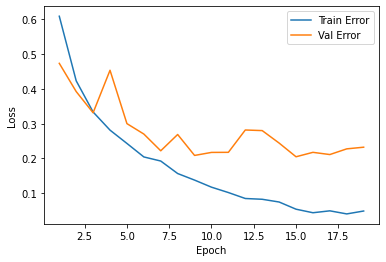

In [22]:
plot_history(history)